In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pymc
import numpy as np
from scipy.stats import bernoulli

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
mu_0, sigma_0 = 0, 2
scale_0, shape_0 = 5, 3
size = 2000

mu_V_real = pymc.Normal('mu_V_real', mu_0, sigma_0)
sigma_V_real = pymc.InverseGamma('sigma_V_real', shape_0, scale_0)
V_real = pymc.Normal('V_real', mu_V_real, sigma_V_real, size=size)

mu_WY_real = pymc.Normal('mu_WY_real', mu_0, sigma_0)
sigma_WY_real = pymc.InverseGamma('sigma_WY_real', shape_0, scale_0)
W_real = pymc.Normal('W_real', mu_WY_real, sigma_WY_real, size=size)
Y_real = pymc.Normal('Y_real', mu_WY_real, sigma_WY_real, size=size)

@pymc.deterministic
def S_real(Y=Y_real, V=V_real, W=W_real):
    d = np.zeros(Y.shape[0], dtype=int)
    d[V > np.minimum(Y, W)] = 1
    d[Y < W] *= 2
    return d


def I_logp(value, S, p):
    diff = np.array(value == S, dtype=int)
    pp = (1 - p) * diff + p * (1 - diff)
    return sum(np.log(pp))

def I_random(S, p):
    b = bernoulli.rvs(p, size=S.shape[0])
    value = (S + p) % 3
    return value


flip_real = pymc.Stochastic( logp = I_logp,
                doc = 'Flip the observed value with probability p.',
                name = 'flip_real',
                parents = {'S': S_real, 'p': 0.01},
                random = I_random,
                trace = True,
                dtype=int,
                rseed = 1.,
                observed = False,
                plot=True,
                verbose = 0)

In [4]:
print mu_V_real.value, sigma_V_real.value
print mu_WY_real.value, sigma_WY_real.value
print S_real.value[:50]
print flip_real.value[:50]

1.21962137176 1.3282398184
-0.304557527113 1.91879848918
[2 2 1 1 2 2 0 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1 1 2 1 2 2
 1 1 1 1 2 2 2 1 2 1 2 1 1]
[2 2 1 1 2 2 0 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1 1 2 1 2 2
 1 1 1 1 2 2 2 1 2 1 2 1 1]


In [5]:
mu_V = pymc.Normal('mu_V', mu_0, sigma_0, value=mu_V_real.value + 1)
sigma_V = pymc.InverseGamma('sigma_V', shape_0, scale_0, value=sigma_V_real + 1)
V = pymc.Normal('V', mu_V, sigma_V, size=size)

mu_WY = pymc.Normal('mu_WY', mu_0, sigma_0, value=mu_WY_real.value + 1)
sigma_WY = pymc.InverseGamma('sigma_WY', shape_0, scale_0, value=sigma_WY_real.value + 1)
W = pymc.Normal('W', mu_WY, sigma_WY, size=size)
Y = pymc.Normal('Y', mu_WY, sigma_WY, value=Y_real.value, observed=True, size=size)

@pymc.deterministic
def S(Y=Y, V=V, W=W):
    d = np.zeros(Y.shape[0], dtype=int)
    d[V > np.minimum(Y, W)] = 1
    d[Y < W] *= 2
    return d

flip = pymc.Stochastic( logp = I_logp,
                doc = 'Flip the observed value with probability p.',
                name = 'flip',
                parents = {'S': S, 'p': 0.01},
                random = I_random,
                trace = True,
                dtype=int,
                rseed = 1.,
                value = flip_real.value,
                observed = True,
                plot=True,
                verbose = 0)

In [6]:
model = pymc.Model([mu_V, sigma_V, V, mu_WY, sigma_WY, W, Y, S, flip])

In [7]:
print mu_V_real.value, sigma_V_real.value
print mu_V.value, sigma_V.value
print ""
print mu_WY_real.value, sigma_WY_real.value
print mu_WY.value, sigma_WY.value

1.21962137176 1.3282398184
2.21962137176 2.3282398184

-0.304557527113 1.91879848918
0.695442472887 2.91879848918


In [8]:
f = 30
print S.value[:f]
print flip.value[:f]
print flip_real.value[:f]

[2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2]
[2 2 1 1 2 2 0 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 2]
[2 2 1 1 2 2 0 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 2]


In [9]:
mcmc = pymc.MCMC(model)
mcmc.sample(500000, burn=0, thin=10)

 [-----------------100%-----------------] 500000 of 500000 complete in 364.8 sec

In [10]:
f = 30
print S.value[:f]
print flip.value[:f]
print flip_real.value[:f]

[2 2 2 1 2 2 0 1 1 2 1 2 2 1 2 2 2 2 2 1 1 2 2 1 2 1 2 2 2 2]
[2 2 1 1 2 2 0 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 2]
[2 2 1 1 2 2 0 1 1 1 1 1 2 1 2 1 2 2 2 1 1 2 1 1 1 1 2 2 2 2]


In [11]:
mu_V_samples = mcmc.trace('mu_V')[:]
sigma_V_samples = mcmc.trace('sigma_V')[:]

mu_WY_samples = mcmc.trace('mu_WY')[:]
sigma_WY_samples = mcmc.trace('sigma_WY')[:]

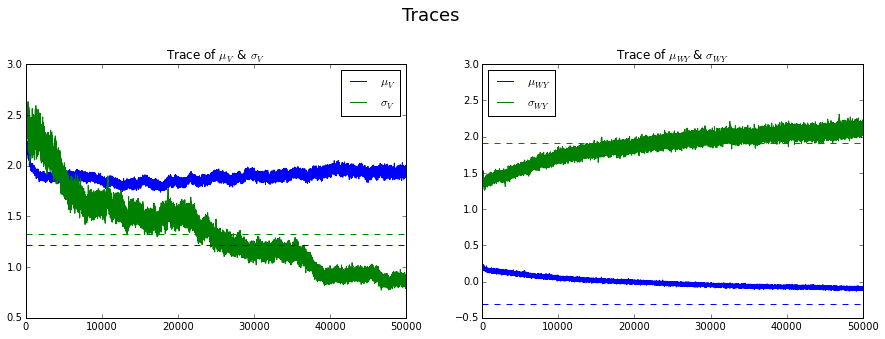

In [12]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(mu_V_samples)
plt.plot(sigma_V_samples)
plt.axhline(mu_V_real.value, linestyle='--')
plt.axhline(sigma_V_real.value, color='g', linestyle='--')
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 2)
plt.plot(mu_WY_samples)
plt.plot(sigma_WY_samples)
plt.axhline(mu_WY_real.value, linestyle='--')
plt.axhline(sigma_WY_real.value, color='g', linestyle='--')
plt.legend([r"$\mu_{WY}$", r"$\sigma_{WY}$"], loc='best')
plt.title(r"Trace of $\mu_{WY}$ & $\sigma_{WY}$")

plt.suptitle(r"Traces", size=18)
plt.show()

In [13]:
flip.logp

-1678.9389376055892

In [11]:
f = 30
print S.value[:f]
print flip.value[:f]
print flip_real.value[:f]

[1 2 0 2 2 0 0 2 0 2 0 0 2 2 0 2 0 2 2 0 1 2 0 2 0 0 2 0 2 0]
[1 2 0 1 2 0 1 2 0 2 0 0 2 2 0 0 1 2 2 0 1 2 0 2 0 0 2 0 0 0]
[1 2 0 1 2 0 1 2 0 2 0 0 2 2 0 0 1 2 2 0 1 2 0 2 0 0 2 0 0 0]


In [48]:
s = mcmc.step_method_dict[W][0]
s

In [49]:
s.markov_blanket

[<pymc.distributions.Normal 'W' at 0x114063d90>,
 <pymc.PyMCObjects.Stochastic 'flip' at 0x113e89c10>]

In [50]:
s.children

{<pymc.PyMCObjects.Stochastic 'flip' at 0x113e89c10>}

In [51]:
W.children

{<pymc.PyMCObjects.Deterministic 'S' at 0x113e89950>,
 <pymc.PyMCObjects.Deterministic '(W_lt_sigma)' at 0x118d34350>,
 <pymc.PyMCObjects.Deterministic '(mu_lt_W)' at 0x113bbe510>,
 <pymc.PyMCObjects.Deterministic '(W_lt_V)' at 0x118d344d0>,
 <pymc.PyMCObjects.Deterministic '(mu_lt_W)' at 0x118d34b10>,
 <pymc.PyMCObjects.Deterministic '(W_lt_V)' at 0x118d34910>,
 <pymc.PyMCObjects.Deterministic '(mu_lt_W)' at 0x118d34c10>}

In [26]:
W_real.children

{<pymc.PyMCObjects.Deterministic 'S_real' at 0x10e835850>}